**Loading and Pre-Processing Data:**

In [2115]:
import pandas as pd
import matplotlib.pyplot as plt

In [2116]:
ev_data=pd.read_csv("licensed_plug-in cars_lgvs_and_quadricycles.csv")

In [2117]:
ev_data

,Unnamed: 0,ONS LA Code,Region/Local Authority,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,2020 Q2,2020 Q1,...,2016 Q2,2016 Q1,2015 Q4,2015 Q3,2015 Q2,2015 Q1,2014 Q4,2014 Q3,2014 Q2,2014 Q1
0,0,K02000001,United Kingdom,621564,543517,468952,413645,355965,300983,283935,...,70677,62779,52246,45667,39588,34016,26004,20768,16018,13615
1,1,K03000001,Great Britain,613930,536948,463377,408857,351808,297356,280478,...,69604,61797,51423,44937,38957,33502,25614,20466,15786,13426
2,2,E92000001,England,554656,485334,418207,369263,317871,268373,255130,...,63436,56119,46566,40359,35148,30215,23075,18244,13961,11932
3,3,E06000023,"Bristol, City of",2405,2134,1881,1747,1521,1306,1221,...,498,424,350,321,283,259,210,170,142,128


In [2118]:
ev_data=ev_data.T

In [2119]:
ev_data=ev_data.iloc[3:34,3]

In [2120]:
ev_data.sort_index(inplace=True)

In [2121]:
ev_data=ev_data.to_frame()

In [2122]:
ev_data.columns=['EV Count']

In [2123]:
import plotly.express as px
fig = px.line(ev_data, x=ev_data.index, y=ev_data['EV Count'],labels={'index':'Quarters','y':'No. of Licensed Plug-in cars, LGVs and Quadricycles'},title="Licensed Battery Electric, Plug-In Hybrid Electric and Range-Extended Electric Vehicles Each Year")
fig.update_layout(plot_bgcolor="white")
fig.update_traces(
    mode='markers+lines',
    marker=dict(color='#FFC048', size=8),
    line=dict(color='#FFC048', width=2),)
#fig.update_xaxes(showgrid=True, gridwidth=-0, gridcolor='rgb(3,153,153)')
fig.update_yaxes(showgrid=True, gridwidth=0, gridcolor='rgb(230,230,230)')
fig.show()

In [2124]:
ev_data.reset_index(inplace=True)

In [2125]:
ev_data.rename(columns={'index':'Quarter'},inplace=True)

In [2126]:
ev_data['date'] = pd.to_datetime(ev_data['Quarter'].str[0:4] + ev_data['Quarter'].str[5:7])

In [2127]:
from fbprophet import Prophet

In [2128]:
ev_data_fb=ev_data[['date','EV Count']]

In [2129]:
ev_data_fb.rename(columns={'date':'ds','EV Count':'y'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [2130]:
train_ev_data_fb=ev_data_fb.loc[16:26,:] # excluding outliers
test_ev_data_fb=ev_data_fb.loc[27:,:]

In [2131]:
train_ev_data_fb

,ds,y
16,2018-01-01,548
17,2018-04-01,608
18,2018-07-01,641
19,2018-10-01,693
20,2019-01-01,744
21,2019-04-01,811
22,2019-07-01,925
23,2019-10-01,1057
24,2020-01-01,1221
25,2020-04-01,1306


**Creating and Testing FBProp Model**:

In [2132]:
model_fb_xg=Prophet(seasonality_prior_scale=0.1) #9
model_fb_xg.fit(train_ev_data_fb)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


In [2133]:
forecast_fb_xg=model_fb_xg.predict(test_ev_data_fb)
comparision_data_fb_xg=pd.DataFrame(index=test_ev_data_fb.index)
forecast_fb_xg.index=test_ev_data_fb.index
comparision_data_fb_xg['Predicted EV Count']=forecast_fb_xg['yhat']
comparision_data_fb_xg['Actual EV Count']=test_ev_data_fb['y']
comparision_data_fb_xg.index=forecast_fb_xg.ds

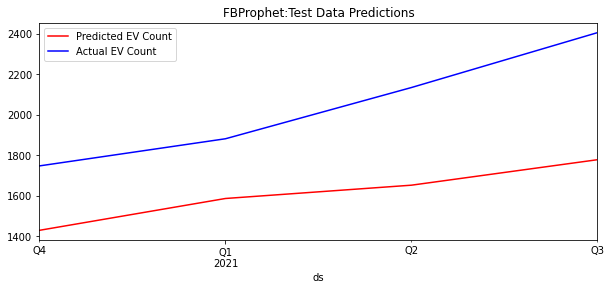

In [2134]:
fig2=comparision_data_fb_xg['Predicted EV Count'].plot(legend=True, color='red', figsize=(10,4))
fig2=comparision_data_fb_xg['Actual EV Count'].plot(legend=True, color='blue')
plt.title("FBProphet:Test Data Predictions")
plt.show()

In [2135]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2136]:
rms_fb_xg=sqrt(mean_squared_error(comparision_data_fb_xg['Actual EV Count'],comparision_data_fb_xg['Predicted EV Count']))

In [2137]:
rms_fb_xg

451.21198991643735

In [2138]:
import numpy as np
rmsp_fb_xg=(np.sqrt(np.mean(np.square((comparision_data_fb_xg['Actual EV Count'] -comparision_data_fb_xg['Predicted EV Count']) /comparision_data_fb_xg['Actual EV Count'])))) * 100
print(rmsp_fb_xg.round(1),'%')

21.0 %


**Final Training:**

In [2139]:
train_ev_data_fb_final=ev_data_fb.loc[21:30,:] # excluding outliers

In [2140]:
model_fb_final=Prophet(seasonality_prior_scale=0.1)
model_fb_final.fit(train_ev_data_fb_final)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


**Forecasting and Visualizing EV Count in Bristol for the Future:**

In [2141]:
future_EV_Count_timestamps=pd.date_range(start='2021/10/01',end='2028/07/01',freq='BQS')
for each in future_EV_Count_timestamps:
  each=each.replace(day=1)
future_EV_Count_timestamps=pd.DataFrame(future_EV_Count_timestamps)
future_EV_Count_timestamps.columns=['ds']


In [2142]:
forecast_fb_xg_EV_Count_future=model_fb_final.predict(future_EV_Count_timestamps)

In [2143]:
forecast_fb_xg_EV_Count_future=forecast_fb_xg_EV_Count_future[['ds','yhat']]

In [2144]:
forecast_fb_xg_EV_Count_future.rename(columns={'yhat':'y'},inplace=True)

In [2145]:
ev_data_final =ev_data_fb.append(forecast_fb_xg_EV_Count_future, ignore_index=True)

In [2149]:
import plotly.offline as pyo
import plotly.graph_objs as go
trace1=go.Scatter(x=forecast_fb_xg_EV_Count_future.ds,
                  y=forecast_fb_xg_EV_Count_future.y,
                  mode='markers+lines',
                  marker=dict(color='green', size=4),
                  line=dict(color='green', width=2),
                  name='Predicted EV Count'
                  )
trace0=go.Scatter(x=ev_data_final.ds,
                  y=ev_data_final.y,
                  name='EV Count 2014-2021',
                  mode='markers+lines',
                  marker=dict(color='#FFC048', size=4),
                  line=dict(color='#FFC048', width=2),
                  )
data=[trace0,trace1]
layout=go.Layout(title='Predicted EV Count in Bristol for the Coming 6 Years',xaxis_title="Month",yaxis_title="EV Count",height=500,width=900)
figure=go.Figure(data=data,layout=layout)
figure.update_layout(plot_bgcolor="white")
figure.update_yaxes(showgrid=True, gridwidth=0, gridcolor='rgb(230,230,230)')
figure.show()